# Calculate metrics using climpred

---

Now that all of our model and observational data is ready for analysis, we can run this notebook and calculate various metrics using climpred across all models and seasons and compare how they do. It is recommended that you use `dask` to run this notebook as we are looking at geospatial data and making maps. You can start up a `dask` cluster by running the notebook `cluster.ipynb` and copying the Scheduler tcp number into this notebook.

In [1]:
import cftime
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True)
import climpred
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.util import add_cyclic_point
import intake
import os.path
from tqdm import tqdm
import dask.array as da
import matplotlib.pyplot as plt
import ultraplot as uplt
from matplotlib.ticker import FixedLocator
import xskillscore as xs
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

ModuleNotFoundError: No module named 'ultraplot'

- Make sure you have copied the correct tcp here from the `cluster.ipynb` notebook

In [2]:
client = Client("tcp://128.117.208.202:39901")

2025-07-24 16:49:29,219 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [3]:
savefig = "no" #yes or no
plotdir = "/glade/work/jaye/climpred/notebooks/S2S/s2s_climo/plots/"

## Here is where you choose your variable, metric and start/end time.

In [4]:
variable = "t2m" #can be t2m, tp, gh_500
metric = "acc" #can be rps, rmse, acc, rpss
state = "soilm" #can be NAO, PNA, ENSO, MJO or just leave it blank
reg = "US_MW" #'US_NE', 'US_Rockies', 'US_NW', 'US_Ohio', 'US_South', 'US_SE', 'US_SW','US_MW', 'US_West'
ld = [1, 15, 31]
weeks = ["wk12","wk34","wk56"]
predict = "hindcast" #can be perfect or hindcast
data = "anom"
lead = "biweekly" #biweekly or daily
area = "geospatial"
start = "1999-01-01"
end = "2020-12-31"
season = "ann" # JJA, DJF, ann
models = ["CESM2_orig","CESM2_climoLND"] #can be ECMWF, NCEP, ECCC, CESM2, CESM1 and WACCM
domain = "namerica" #can be global or namerica

In [5]:
# Here we are just setting options for the different metrics and mapping.
if metric == "acc":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="YlOrRd" #options for maps
    if variable=="t2m":
        vmin=-1.0; vmax=1.0
    elif variable=="tp":
        vmin=-0.7; vmax=0.7
elif metric=="rmse":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="viridis"; vmin=0.0; vmax=5.0 #options for maps
elif metric=="rps":
    comp="m2o"; dim=["init","member"]; ens="" #options for metrics
    cmap="viridis"; vmin=0.0; vmax=1.0 #options for maps
elif metric=="rpss":
    comp="m2o"; dim=["init","member"]; ens="" #options for metrics
    cmap="RdBu_r"; vmin=-0.8; vmax=0.8 #options for maps

## Now we read in and load the data into `dask`

We are using the intake catalog to find the data and load it up. Make sure you have the file `ASP_data_catalog.yml` in your local directory. Or you can find it here: `/glade/campaign/mmm/c3we/jaye/S2S_zarr/`

We have an `if` statement here telling us to load in category_edge files, only if our metric of choice is `rps`

In [6]:
cat = intake.open_catalog('/glade/campaign/mmm/c3we/jaye/S2S_zarr/ASP_data_catalog.yml')

In [7]:
hinds = {}
for m in models:
    hinds[m] = cat[m](data=data, lead=lead, dim=area).to_dask().astype('float32')
    if domain == "namerica":
        hinds[m] = hinds[m].sel(lat=slice(15.0, 75.0),lon=slice(190.0, 305.0))
verif = cat['OBS_SUBX'](data=data, lead=lead, dim=area).to_dask().astype('float32')
if domain == "namerica":
    verif = verif.sel(lat=slice(15.0, 75.0),lon=slice(190.0, 305.0))

- All of the model data is now loaded into a dictionary so that we can have them all together for comparison purposes.

In [8]:
# is seasonal data available for all models and rechunk
for h in hinds:
    print(hinds[h].init.dt.season.to_index().unique(), 'freq =',hinds[h].init.to_index().freq) # freq would show weekly but calendar conversion breaks this
    hinds[h] = hinds[h].chunk({"member": "auto", "init": -1, "lead": "auto", "lat": 45, "lon": 60}).persist()
    hinds[h] = hinds[h].sel(init=slice(start,end))
    hinds[h] = hinds[h].where(-88.6<hinds[h].lat)
    hinds[h] = hinds[h].where(88.6>hinds[h].lat)
verif = verif.sel(time=slice(start,str(pd.to_datetime(end)+pd.DateOffset(days=46))))
if data=="raw" and variable=="t2m":
    verif = verif.chunk({"time": -1, "lat": 45, "lon": 60})+273.15
else:
    verif = verif.chunk({"time": -1, "lat": 45, "lon": 60})

Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None
Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None


In [9]:
lmask = np.isnan(verif.t2m[0,:,:]).drop(["time"]) # making a landmask from the CPC data

In [31]:
if state=="soilm":
    # soilm = xr.open_dataset("/glade/work/jaye/climpred/data/catDS_SMterciles_NOAAregions.nc")
    soilm = xr.open_dataset("catDS_SMterciles_JJA_HUC2.nc")
    mask_neu = soilm["soilTercileCategory"].sel(region=reg) == "neutral"; neu = soilm.sel(region=reg).where(mask_neu, drop=True)
    mask_mix = soilm["soilTercileCategory"].sel(region=reg) == "mixed";   mix = soilm.sel(region=reg).where(mask_mix, drop=True)
    mask_dry = soilm["soilTercileCategory"].sel(region=reg) == "dry";     dry = soilm.sel(region=reg).where(mask_dry, drop=True)
    mask_wet = soilm["soilTercileCategory"].sel(region=reg) == "wet";     wet = soilm.sel(region=reg).where(mask_wet, drop=True)
    neu["init"] = [cftime.DatetimeProlepticGregorian(pd.DatetimeIndex([d]).year[0], \
                                                     pd.DatetimeIndex([d]).month[0], \
                                                     pd.DatetimeIndex([d]).day[0]) for d in neu.init.values]
    mix["init"] = [cftime.DatetimeProlepticGregorian(pd.DatetimeIndex([d]).year[0], \
                                                     pd.DatetimeIndex([d]).month[0], \
                                                     pd.DatetimeIndex([d]).day[0]) for d in mix.init.values]
    dry["init"] = [cftime.DatetimeProlepticGregorian(pd.DatetimeIndex([d]).year[0], \
                                                     pd.DatetimeIndex([d]).month[0], \
                                                     pd.DatetimeIndex([d]).day[0]) for d in dry.init.values]
    wet["init"] = [cftime.DatetimeProlepticGregorian(pd.DatetimeIndex([d]).year[0], \
                                                     pd.DatetimeIndex([d]).month[0], \
                                                     pd.DatetimeIndex([d]).day[0]) for d in wet.init.values]

In [32]:
mix

<xarray.Dataset> Size: 952B
Dimensions:              (init: 57)
Coordinates:
    region               <U10 40B 'US_MW'
  * init                 (init) object 456B 1999-01-04 00:00:00 ... 2023-06-1...
Data variables:
    soilTercileCategory  (init) object 456B 'mixed' 'mixed' ... 'mixed' 'mixed'

## Create a Hindcast Ensemble in climpred for each of the models and run metrics

We are also setting kwargs (options) for `verify` in climpred. The second cell does the metric calculation using `verify` and computes it. Finally all models are concatenated together and plotted.

This could take a few minutes to run. If you are curious, check out the `dask` dashboard and you can watch the progress of the computations. The link should be like this: `https://jupyterhub.hpc.ucar.edu/stable/user/jaye/proxy/37030/status`. The number between proxy and status will vary. Your link will be available where you started your dask cluster in `cluster.ipynb`

In [33]:
heneu = {}; hemix = {}; hedry = {}; hewet = {}
metneu = {}; metmix = {}; metdry = {}; metwet = {}
hindsneu = {}; hindsmix = {}; hindsdry = {}; hindswet = {}
for h in hinds:
    print(h)
    if season=="JJA":
        hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([6,7,8]), drop=True)
    elif season=="DJF":
        hinds[h] = hinds[h].where(hinds[h].init.dt.month.isin([1,2,12]), drop=True)
    hindsneu[h] = hinds[h].sel(init=np.intersect1d(hinds[h].init,neu.init))
    hindsmix[h] = hinds[h].sel(init=np.intersect1d(hinds[h].init,mix.init))
    hindsdry[h] = hinds[h].sel(init=np.intersect1d(hinds[h].init,dry.init))
    hindswet[h] = hinds[h].sel(init=np.intersect1d(hinds[h].init,wet.init))

    hindsneu[h]["t2m"] = hindsneu[h].t2m.where(lmask==False); hindsdry[h]["t2m"] = hindsdry[h].t2m.where(lmask==False);
    hindsmix[h]["t2m"] = hindsmix[h].t2m.where(lmask==False); hindswet[h]["t2m"] = hindswet[h].t2m.where(lmask==False);
    hindsneu[h]["tp"] = hindsneu[h].t2m.where(lmask==False); hindsdry[h]["tp"] = hindsdry[h].t2m.where(lmask==False);
    hindsmix[h]["tp"] = hindsmix[h].t2m.where(lmask==False); hindswet[h]["tp"] = hindswet[h].t2m.where(lmask==False);

    hindsneu[h]['lead'] = [1, 15, 31]; hindsmix[h]['lead'] = [1, 15, 31]; hindsdry[h]['lead'] = [1, 15, 31]; hindswet[h]['lead'] = [1, 15, 31];
    hindsneu[h]['lead'].attrs['units'] = 'days'; hindsmix[h]['lead'].attrs['units'] = 'days';
    hindsdry[h]['lead'].attrs['units'] = 'days'; hindswet[h]['lead'].attrs['units'] = 'days';
    hindsneu[h] = hindsneu[h][variable]; hindsmix[h] = hindsmix[h][variable];
    hindsdry[h] = hindsdry[h][variable]; hindswet[h] = hindswet[h][variable];
    
    if predict == "perfect":
        hes[h] = climpred.PerfectModelEnsemble(hindss[h])
        hen[h] = climpred.PerfectModelEnsemble(hindsn[h])
        metric_kwargs = dict(metric=metric,comparison="e2c",dim=dim,alignment="same_inits",reference=None,\
                             resample_dim="member",sig=95,iterations=50,skipna=True)
    elif predict == "hindcast":
        heneu[h] = climpred.HindcastEnsemble(hindsneu[h]).add_observations(verif)
        hemix[h] = climpred.HindcastEnsemble(hindsmix[h]).add_observations(verif)
        hedry[h] = climpred.HindcastEnsemble(hindsdry[h]).add_observations(verif)
        hewet[h] = climpred.HindcastEnsemble(hindswet[h]).add_observations(verif)
        metric_kwargs = dict(metric=metric,comparison=comp,dim=dim,alignment="same_inits",reference=None,\
                             resample_dim="init",sig=95,iterations=50,skipna=True)
    metneu[h] = heneu[h].bootstrap(**metric_kwargs)
    metmix[h] = hemix[h].bootstrap(**metric_kwargs)
    metdry[h] = hedry[h].bootstrap(**metric_kwargs)
    metwet[h] = hewet[h].bootstrap(**metric_kwargs)

    metneu[h] = metneu[h].compute()
    metmix[h] = metmix[h].compute()
    metdry[h] = metdry[h].compute()
    metwet[h] = metwet[h].compute()

CESM2_orig


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

CESM2_climoLND


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
met_allneu = xr.concat([metneu[models[0]], metneu[models[1]]], dim='model') \
                       .assign_coords(model=[models[0], models[1]]).drop('skill')
met_allmix = xr.concat([metmix[models[0]], metmix[models[1]]], dim='model') \
                       .assign_coords(model=[models[0], models[1]]).drop('skill')
met_alldry = xr.concat([metdry[models[0]], metdry[models[1]]], dim='model') \
                       .assign_coords(model=[models[0], models[1]]).drop('skill')
met_allwet = xr.concat([metwet[models[0]], metwet[models[1]]], dim='model') \
                       .assign_coords(model=[models[0], models[1]]).drop('skill')

newmix = met_allmix.where(met_allmix.sel(results="verify skill")<met_allneu.sel(results="low_ci")).fillna(0)
new2mix = met_allmix.where(met_allmix.sel(results="verify skill")>met_allneu.sel(results="high_ci")).fillna(0)
new3mix = newmix+new2mix
new3mix = new3mix.where(new3mix != 0)
newdry = met_alldry.where(met_alldry.sel(results="verify skill")<met_allneu.sel(results="low_ci")).fillna(0)
new2dry = met_alldry.where(met_alldry.sel(results="verify skill")>met_allneu.sel(results="high_ci")).fillna(0)
new3dry = newdry+new2dry
new3dry = new3dry.where(new3dry != 0)
newwet = met_allwet.where(met_allwet.sel(results="verify skill")<met_allneu.sel(results="low_ci")).fillna(0)
new2wet = met_allwet.where(met_allwet.sel(results="verify skill")>met_allneu.sel(results="high_ci")).fillna(0)
new3wet = newwet+new2wet
new3wet = new3wet.where(new3wet != 0)

In [35]:
if state=="soilm":
    sign = ["neutral","mixed","dry","wet"]
    met_all = xr.concat([met_allneu,met_allmix,met_alldry,met_allwet],dim='sign').assign_coords(sign=sign)
met_all = met_all.compute()

In [36]:
modeln = ["CESM2_orig","CESM2_climoLND","climoLND - orig"]

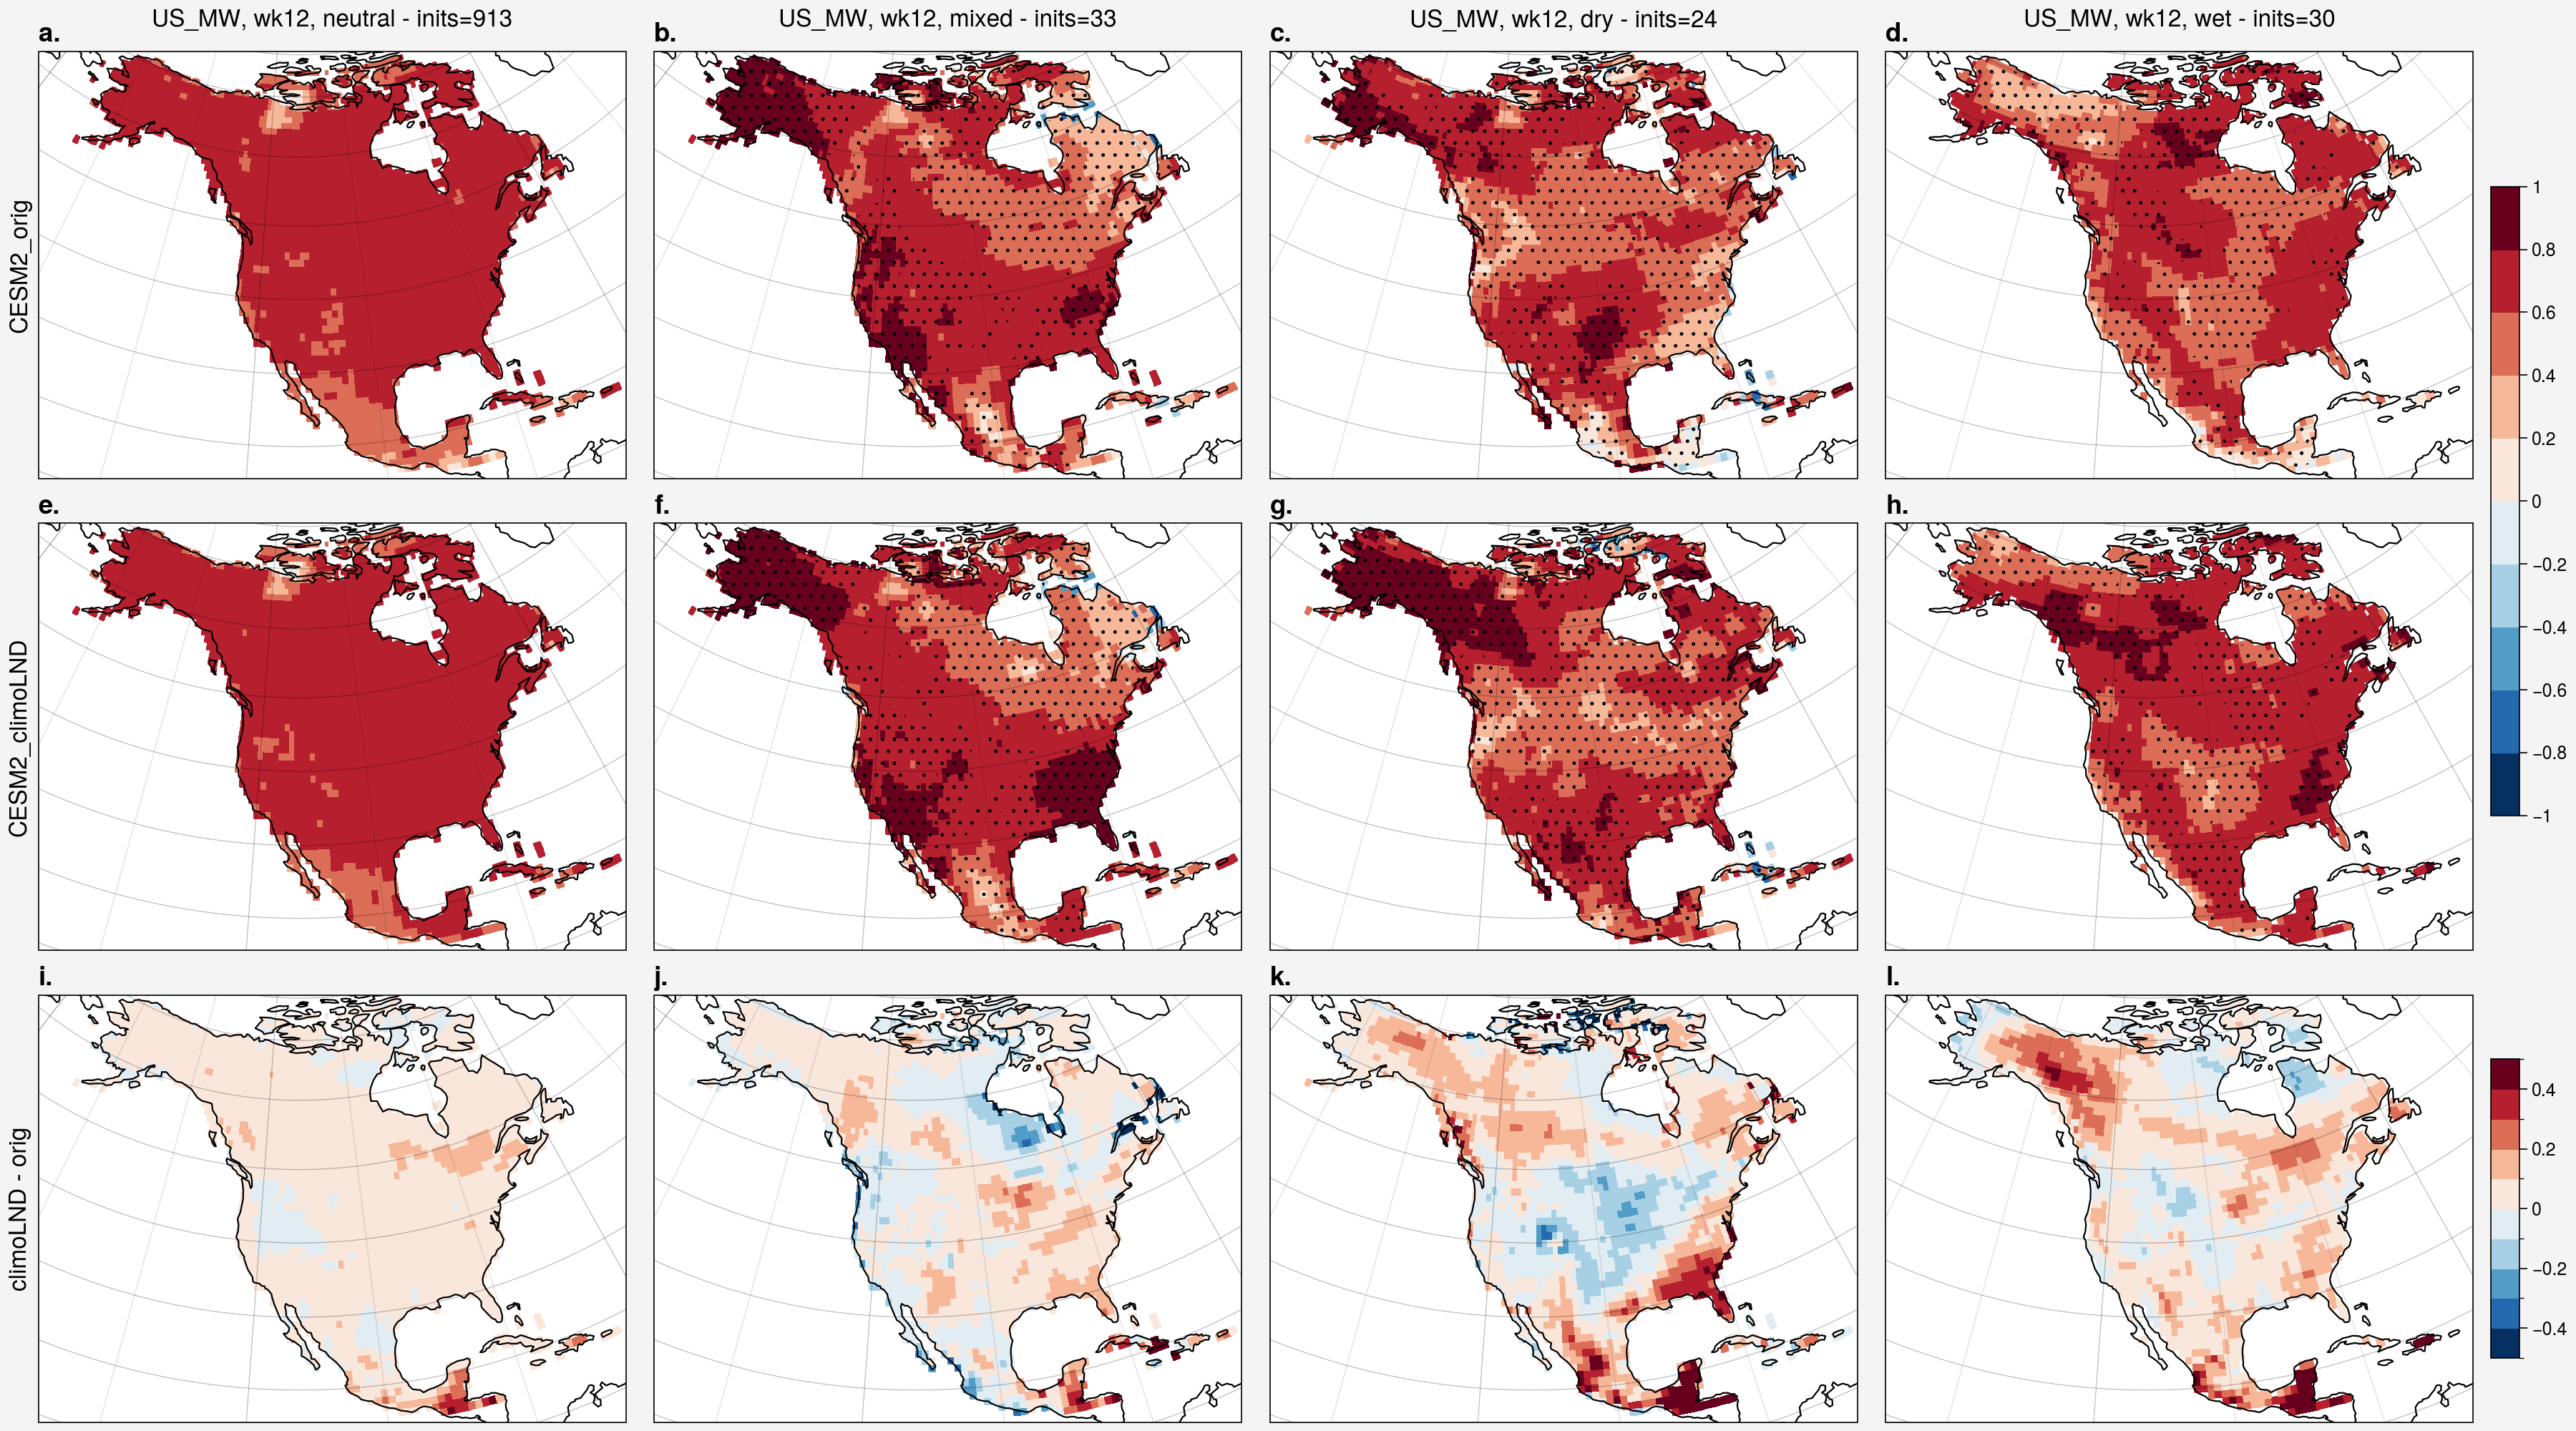

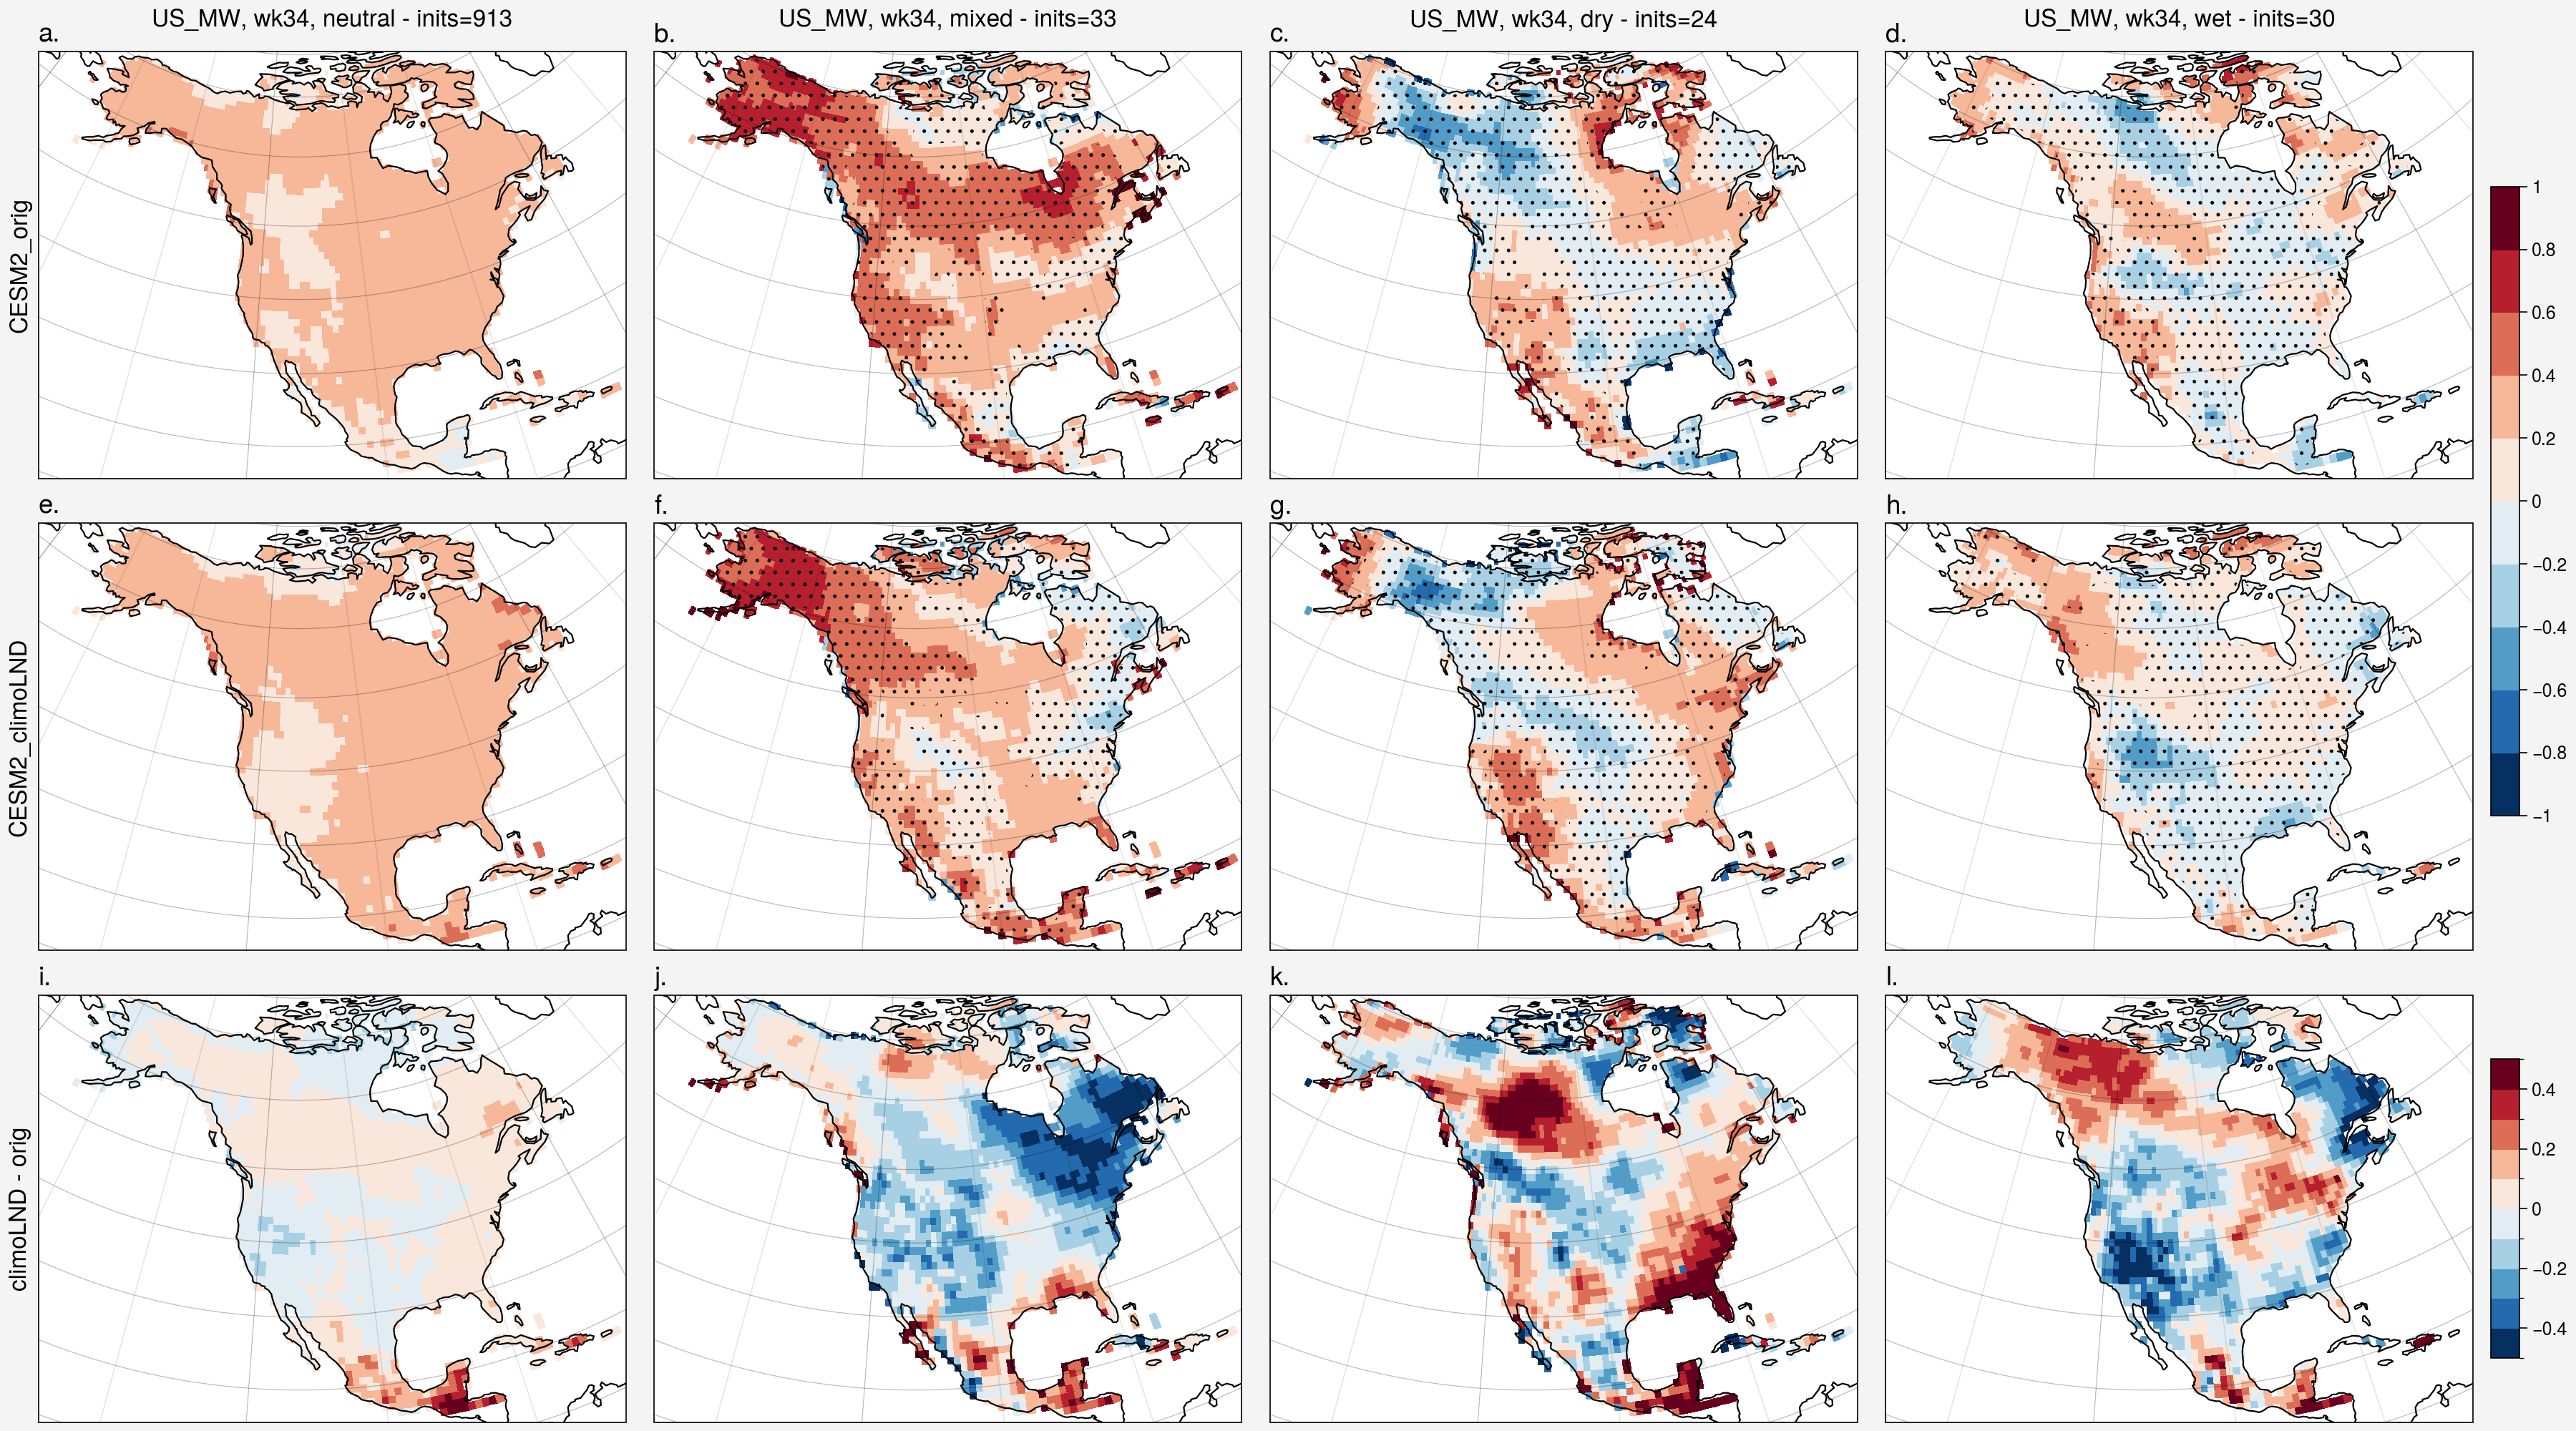

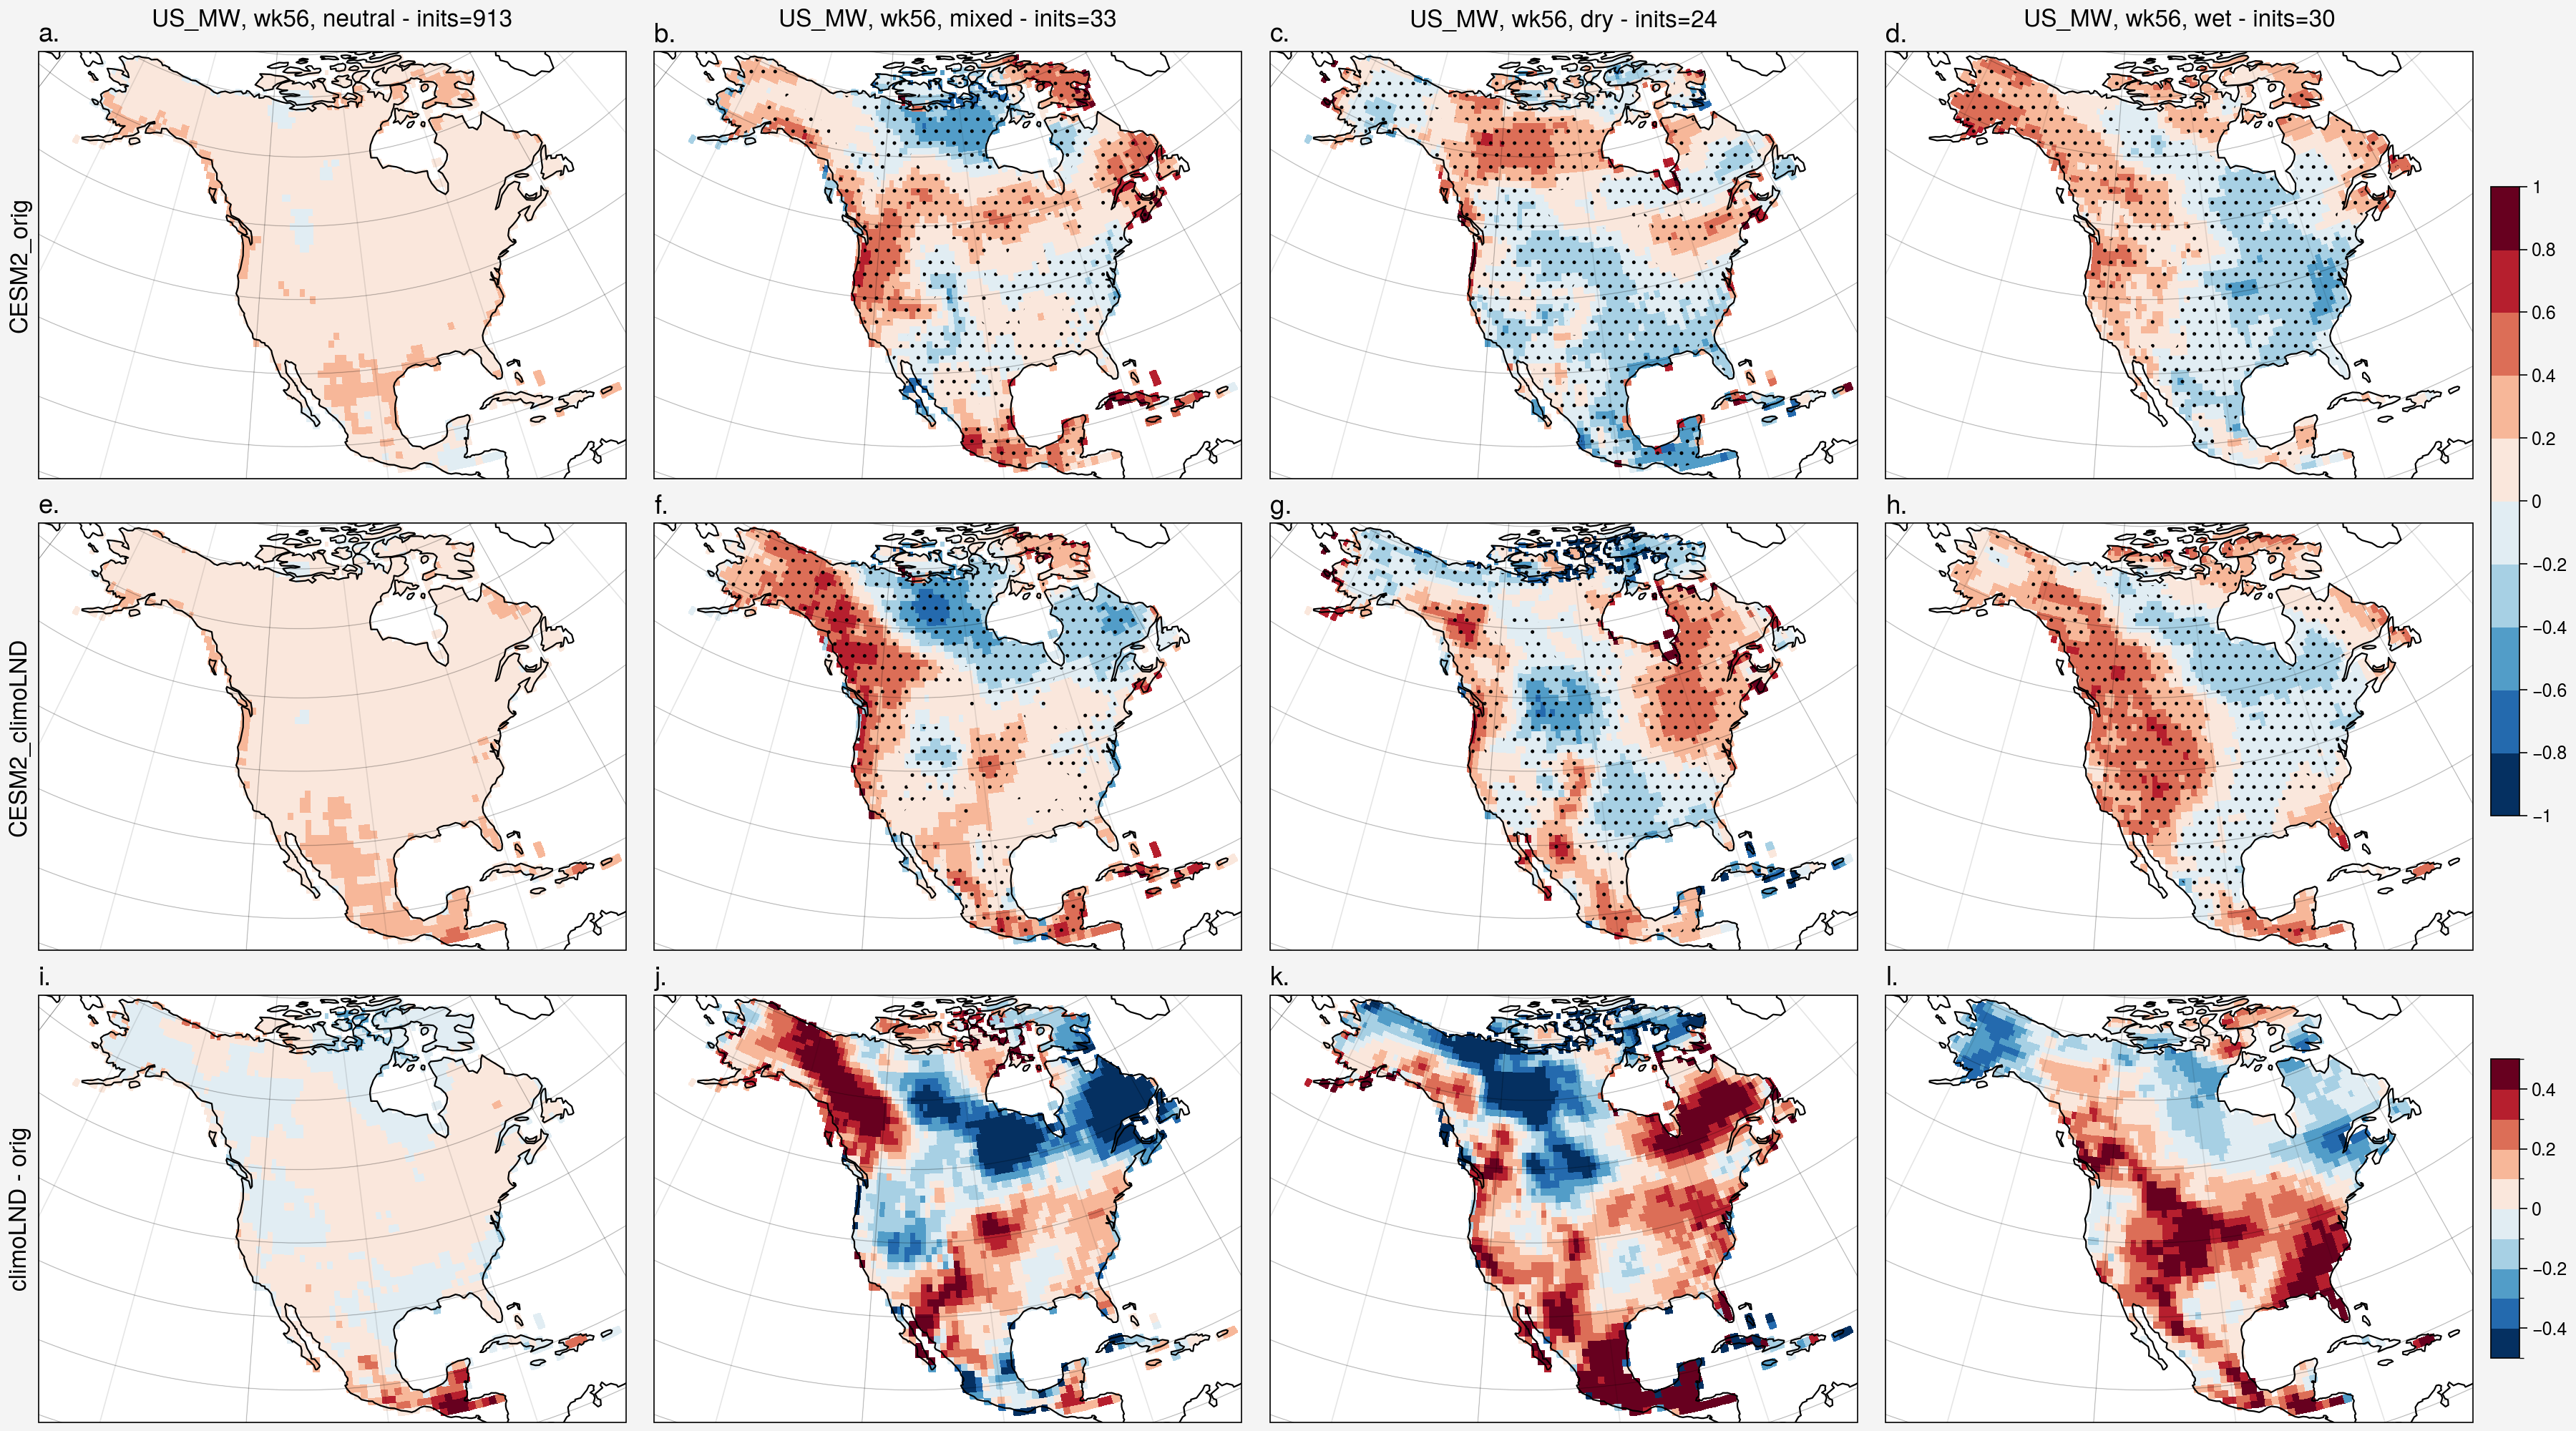

In [37]:
for ll in range(0,3):
    signlab = [reg+", "+weeks[ll]+", neutral - inits="+str(hindsneu["CESM2_orig"].init.shape[0]),reg+", "+weeks[ll]+", mixed - inits="+str(hindsmix["CESM2_orig"].init.shape[0]),\
               reg+", "+weeks[ll]+", dry - inits="+str(hindsdry["CESM2_orig"].init.shape[0]),reg+", "+weeks[ll]+", wet - inits="+str(hindswet["CESM2_orig"].init.shape[0])]
    if domain == "global":
        fig = uplt.figure(figsize=(21,9),hspace=2.5,wspace=1,share=0)
        axs = fig.subplots(ncols=4,nrows=3,space=0,proj="robin",proj_kw={"lon0": 0.0})
    else:
        fig = uplt.figure(figsize=(18,10),hspace=2.5,wspace=1,share=0)
        axs = fig.subplots(ncols=4,nrows=3,space=0,proj="aea",proj_kw={"lon0": 247.5, "lat0": 45})
    uplt.rc["abc.weight"] = "normal"
    axs.format(abc='a.',fontsize=12)
    aa = 0
    kwargs = dict(cmap="RdBu_r",vmin=-1.0,vmax=1.0)
    for pp in modeln:
        for mm in met_all.sign:
            if domain == "global":
                if pp=="CESM2_orig" or pp=="CESM2_climoLND":
                    wrap_data, wrap_lon = add_cyclic_point(met_all[variable].sel(results="verify skill",model=pp,sign=mm,lead=ld[ll]),\
                                                           coord=met_all['lon'])
                    wrap_data[:,360] = wrap_data[:,359]; wrap_data[:,0] = wrap_data[:,1]
                    cont = axs[aa].pcolormesh(wrap_lon,met_all.lat,wrap_data,cmap="RdBu_r",vmin=vmin,vmax=vmax,\
                                              transform=ccrs.PlateCarree())
                    if mm=="mixed":
                        wrap_stip_mix, wrap_lon_mix = add_cyclic_point(new3mix[variable].sel(results="verify skill",model=pp,lead=ld[ll]),\
                                                                        coord=new3mix['lon'])
                        wrap_stip_mix[:,360] = wrap_stip_mix[:,359]; wrap_stip_mix[:,0] = wrap_stip_mix[:,1]
                        stip_mix = axs[aa].contourf(wrap_lon_mix,new3mix.lat,wrap_stip_mix,hatches=[2*'.'],alpha=0)
                    elif mm=="dry":
                        wrap_stip_dry, wrap_lon_dry = add_cyclic_point(new3dry[variable].sel(results="verify skill",model=pp,lead=ld[ll]),\
                                                                        coord=new3dry['lon'])
                        wrap_stip_dry[:,360] = wrap_stip_dry[:,359]; wrap_stip_dry[:,0] = wrap_stip_dry[:,1]
                        stip_dry = axs[aa].contourf(wrap_lon_dry,new3dry.lat,wrap_stip_dry,hatches=[2*'.'],alpha=0)
                    elif mm=="wet":
                        wrap_stip_wet, wrap_lon_wet = add_cyclic_point(new3wet[variable].sel(results="verify skill",model=pp,lead=ld[ll]),\
                                                                        coord=new3wet['lon'])
                        wrap_stip_wet[:,360] = wrap_stip_wet[:,359]; wrap_stip_wet[:,0] = wrap_stip_wet[:,1]
                        stip_wet = axs[aa].contourf(wrap_lon_wet,new3wet.lat,wrap_stip_wet,hatches=[2*'.'],alpha=0)
                elif pp=="climoLND - orig":
                    datan = met_all[variable].sel(results="verify skill",model="CESM2_climoLND",sign=mm,lead=ld[ll])- \
                            met_all[variable].sel(results="verify skill",model="CESM2_orig",sign=mm,lead=ld[ll])
                    wrap_data, wrap_lon = add_cyclic_point(datan,coord=met_all['lon'])
                    wrap_data[:,360] = wrap_data[:,359]; wrap_data[:,0] = wrap_data[:,1]
                    cont2 = axs[aa].pcolormesh(wrap_lon,met_all.lat,wrap_data,cmap="RdBu_r",vmin=-0.5,vmax=0.5,\
                                              transform=ccrs.PlateCarree())                
            else:
                if pp=="CESM2_orig" or pp=="CESM2_climoLND":
                    cont = axs[aa].pcolormesh(met_all.lon,met_all.lat,met_all[variable].sel(results="verify skill",model=pp,sign=mm,lead=ld[ll]),
                                              cmap="RdBu_r",vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
                    if mm=="mixed":
                        stip = axs[aa].contourf(new3mix.lon,new3mix.lat,new3mix[variable].sel(results="verify skill",model=pp,lead=ld[ll]),\
                                                hatches=[2*'.'],alpha=0)
                    elif mm=="dry":
                        stip = axs[aa].contourf(new3dry.lon,new3dry.lat,new3dry[variable].sel(results="verify skill",model=pp,lead=ld[ll]),\
                                                hatches=[2*'.'],alpha=0)
                    elif mm=="wet":
                        stip = axs[aa].contourf(new3wet.lon,new3wet.lat,new3wet[variable].sel(results="verify skill",model=pp,lead=ld[ll]),\
                                                hatches=[2*'.'],alpha=0)
                    axs[aa].set_extent([210,295,15,72])
                elif pp=="climoLND - orig":
                    datan = met_all[variable].sel(results="verify skill",model="CESM2_climoLND",sign=mm,lead=ld[ll])- \
                            met_all[variable].sel(results="verify skill",model="CESM2_orig",sign=mm,lead=ld[ll])
                    cont2 = axs[aa].pcolormesh(met_all.lon,met_all.lat,datan,cmap="RdBu_r", \
                                               vmin=-0.5,vmax=0.5,transform=ccrs.PlateCarree())
                    axs[aa].set_extent([210,295,15,72])
            axs[aa].coastlines('110m',linewidth=0.8)
            axs[aa].gridlines(crs=ccrs.PlateCarree(),x_inline=False,y_inline=False,linewidth=0.2,color='k',alpha=0.3)
            if aa==0:
                axs[aa].text(0.5, 1.1, signlab[0], va='top', ha='center',\
                             rotation='horizontal', rotation_mode='anchor',\
                             transform=axs[aa].transAxes,fontsize=12)
            if aa==1:
                axs[aa].text(0.5, 1.1, signlab[1], va='top', ha='center',\
                             rotation='horizontal', rotation_mode='anchor',\
                             transform=axs[aa].transAxes,fontsize=12)
            if aa==2:
                axs[aa].text(0.5, 1.1, signlab[2], va='top', ha='center',\
                             rotation='horizontal', rotation_mode='anchor',\
                             transform=axs[aa].transAxes,fontsize=12)
            if aa==3:
                axs[aa].text(0.5, 1.1, signlab[3], va='top', ha='center',\
                             rotation='horizontal', rotation_mode='anchor',\
                             transform=axs[aa].transAxes,fontsize=12)
            if aa==0 or aa==4 or aa==8:
                axs[aa].text(-0.05, 0.5, '{}'.format(np.array(pp)), va='top', ha='center',\
                             rotation='vertical', rotation_mode='anchor',\
                             transform=axs[aa].transAxes,fontsize=12)
            aa += 1
    fig.subplots_adjust(right=0.85)
    fig.colorbar(cont,loc="r",rows=[1,2],shrink=0.7,label="")
    fig.colorbar(cont2,loc="r",rows=3,label="",shrink=0.7)
    #fig.suptitle(metric.upper()+' for '+data+' '+variable+' '+predict,fontsize=30,y=0.95)
    if savefig=="yes":
        plt.savefig(plotdir+metric.upper()+"_climoLND_"+state+"_"+reg+"_"+variable+"_"+domain+"_"+weeks[ll]+"_"+season+".jpg",dpi=300,bbox_inches="tight")

## Area weighting

Next we run cosine area weighting over that data to get a weighted lat/lon average over the domain. We then print out the weights and plot them on bar charts to compare different seasons and models.

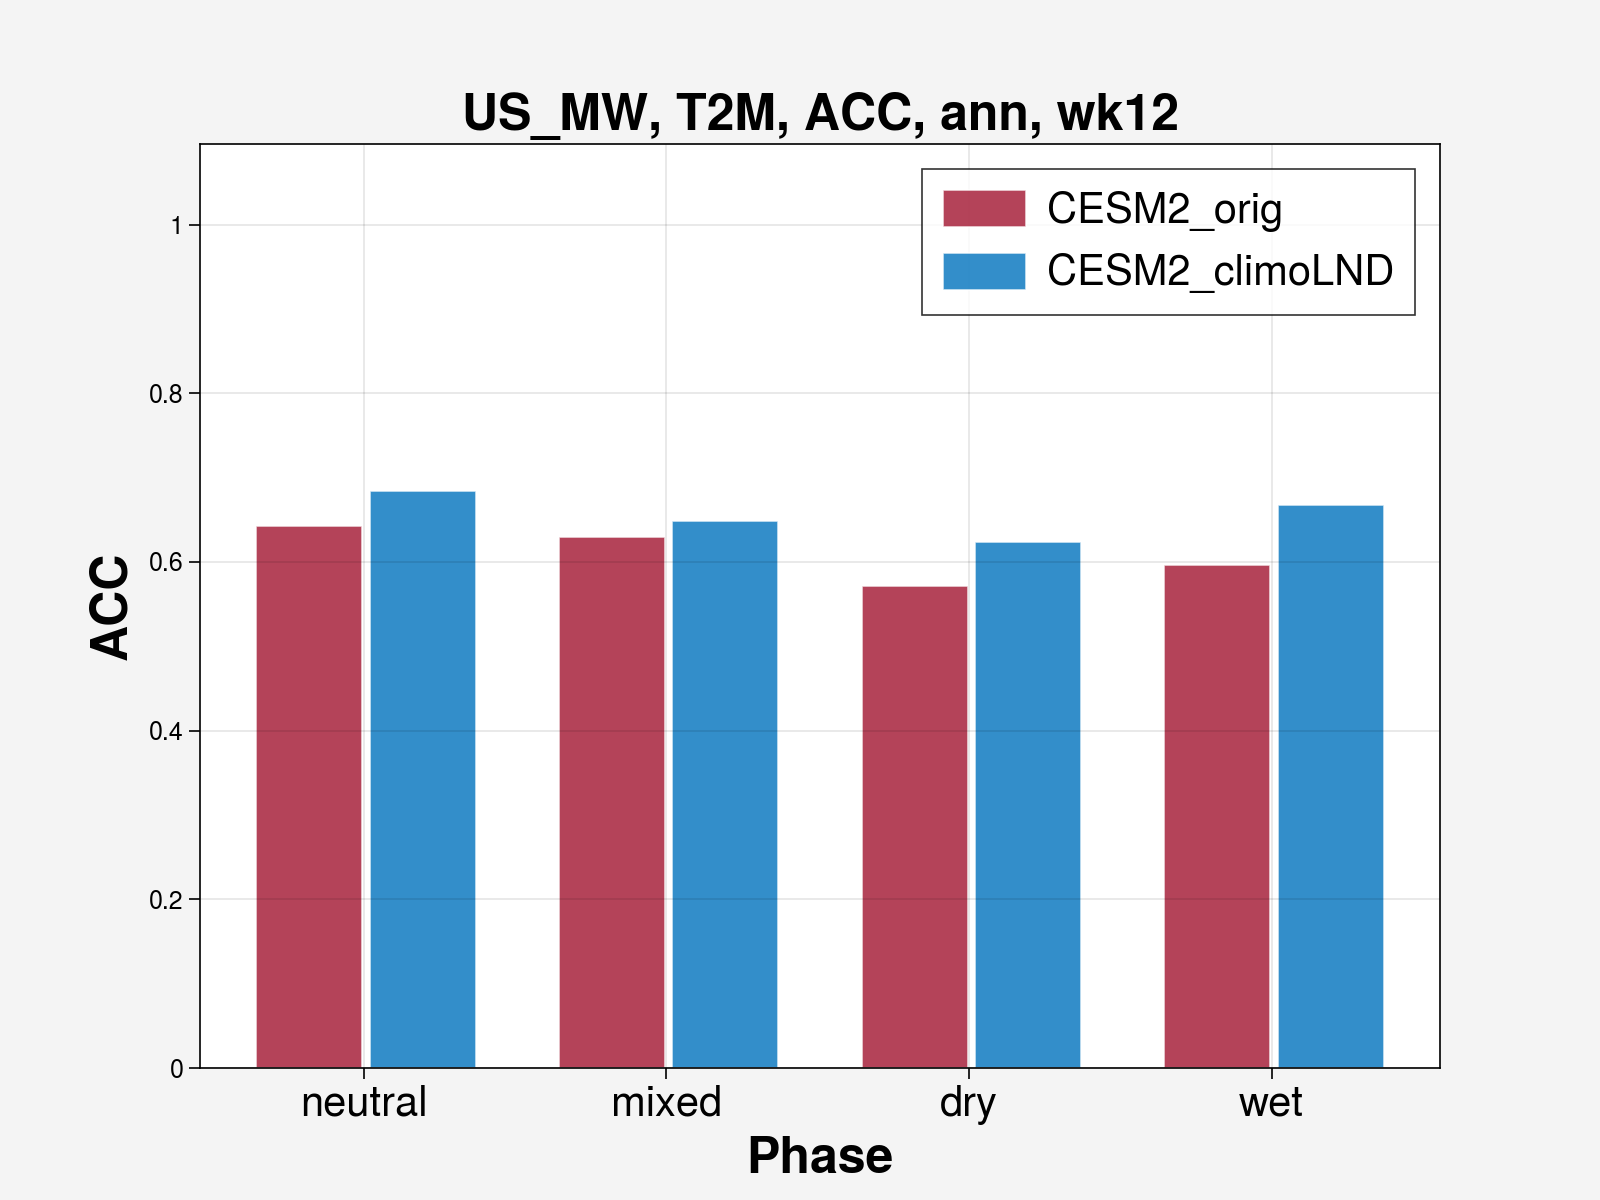

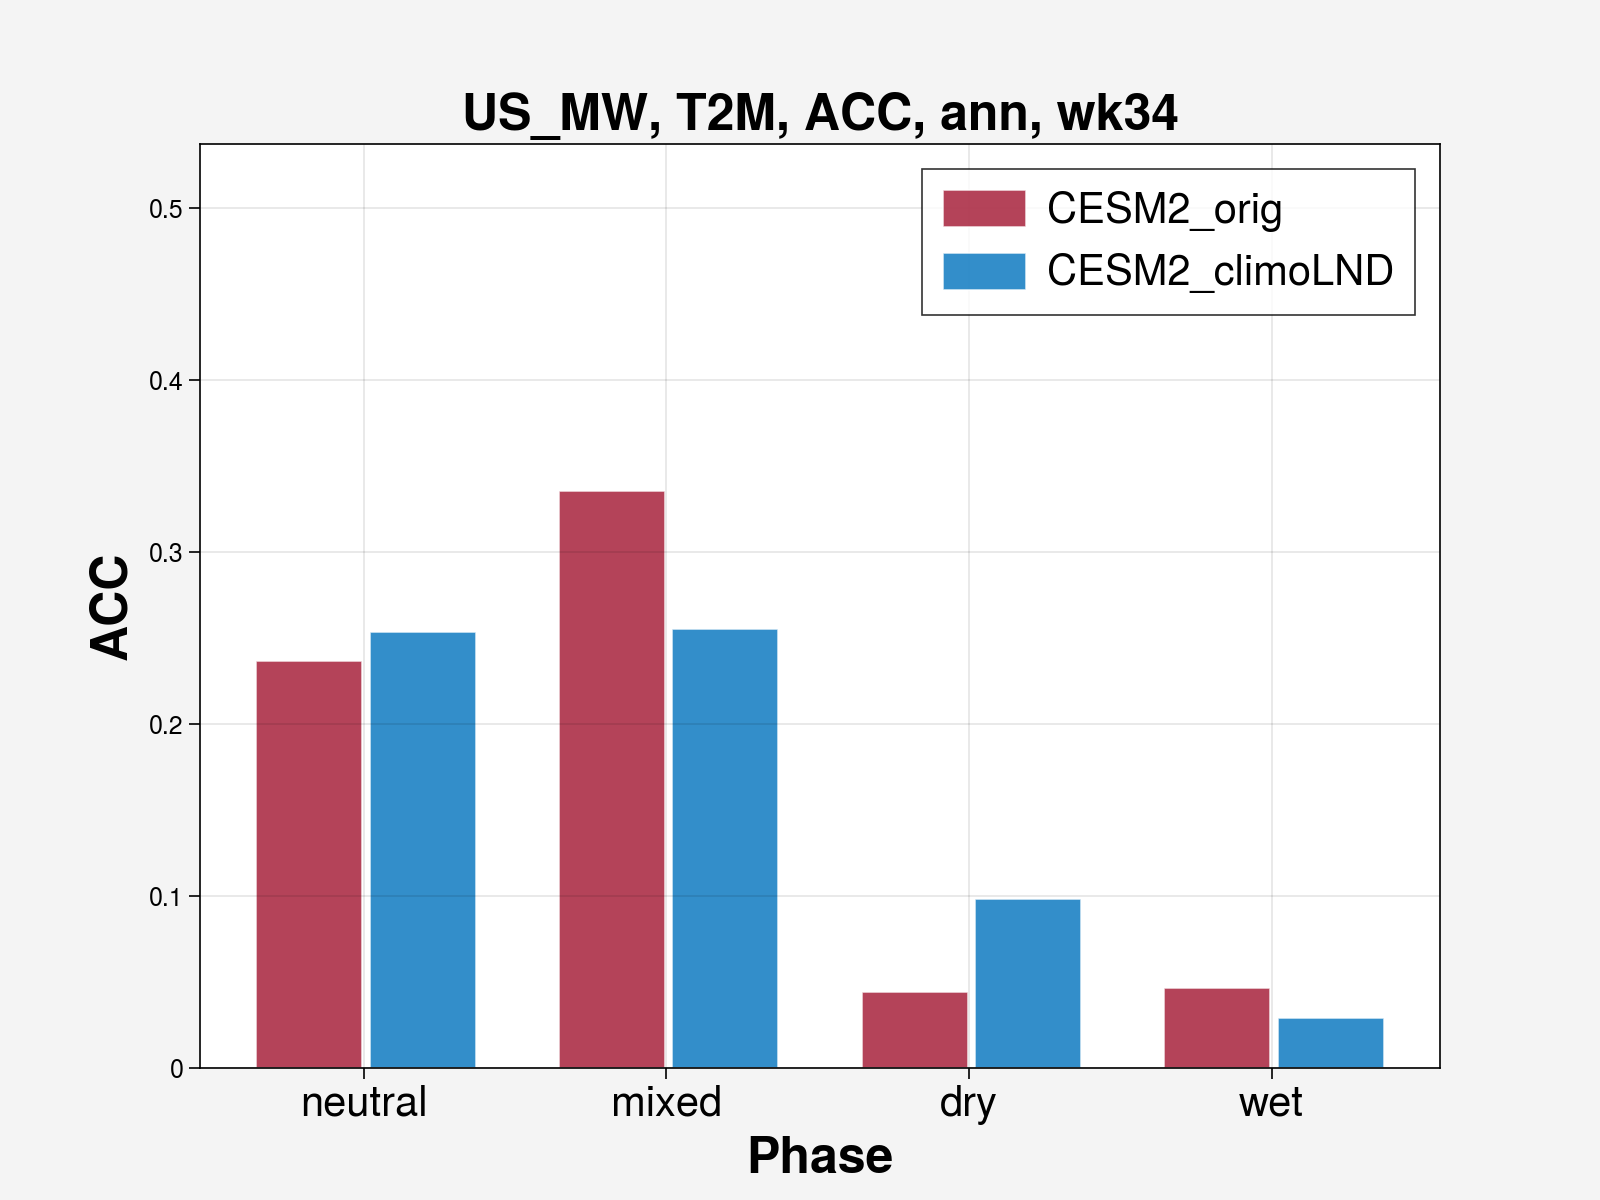

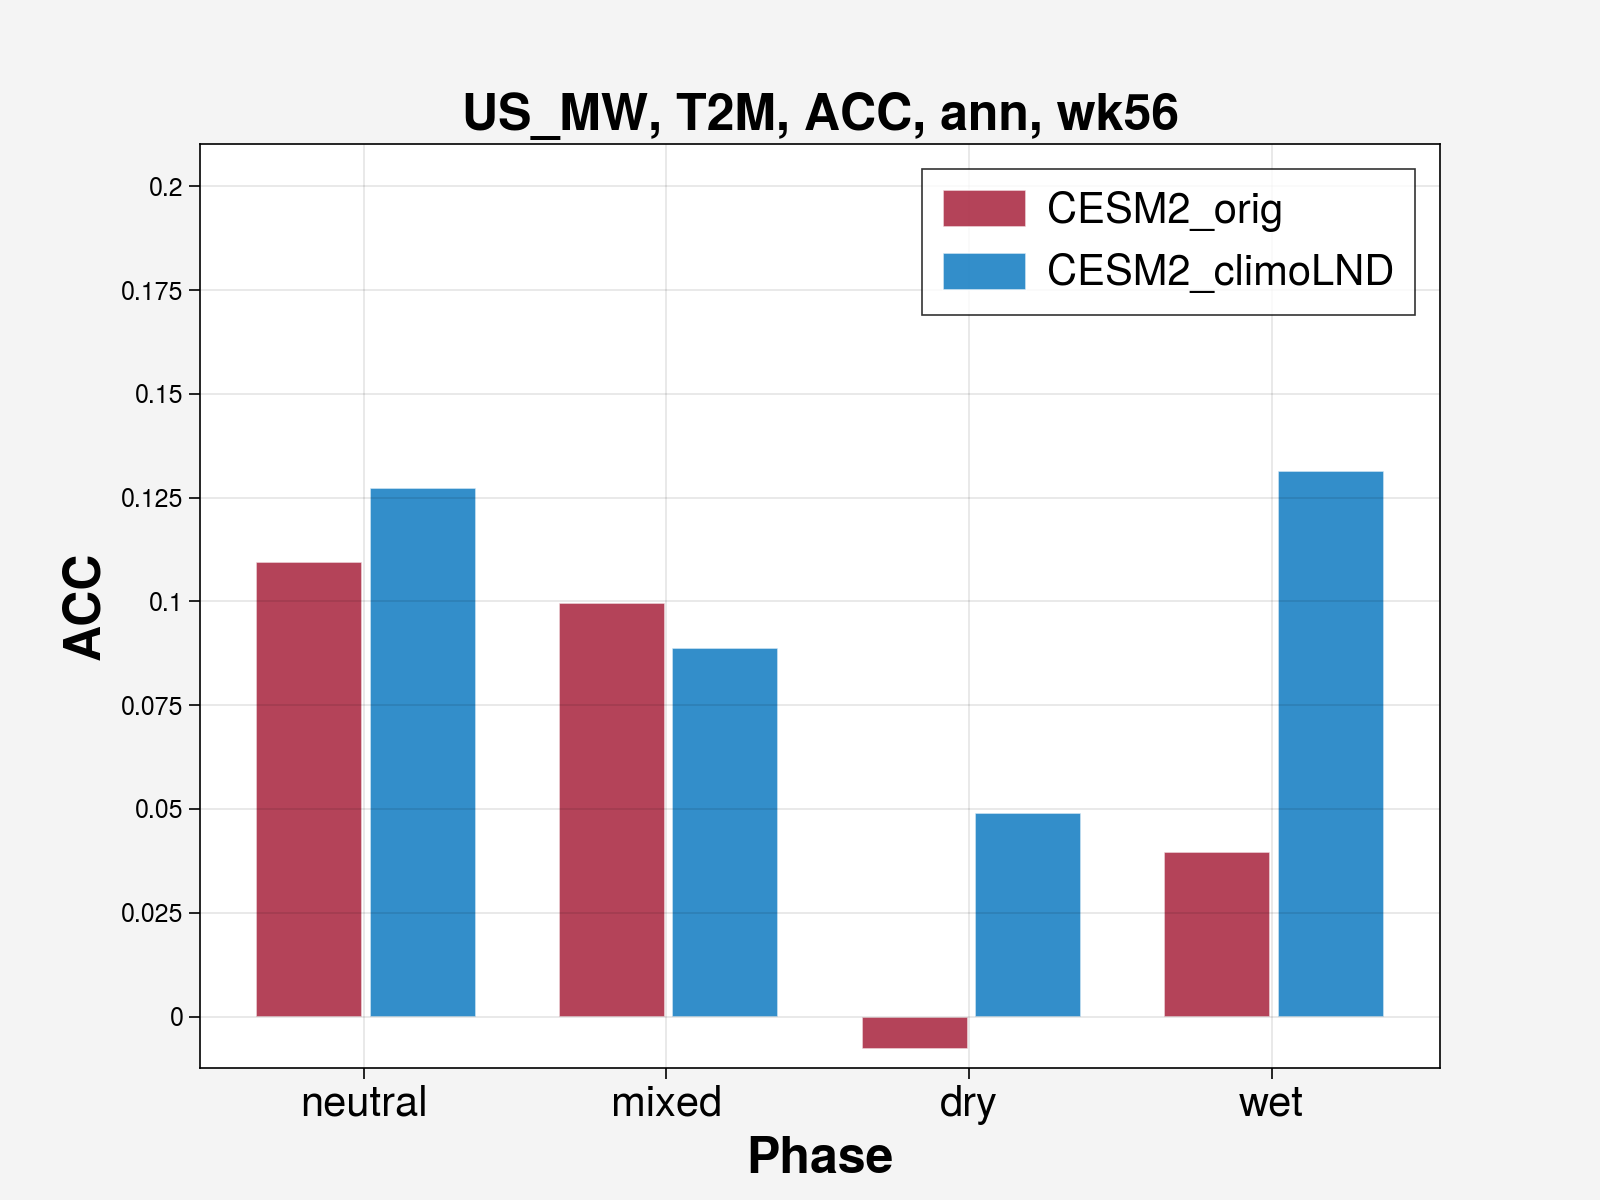

In [114]:
for ll in range(0,3):
    weight = met_all.sel(results="verify skill",lead=ld[ll]).weighted(np.cos(np.deg2rad(met_all.lat))).mean(("lat", "lon"))[variable].compute()
    barWidth = 0.35
    rw = np.arange(4)
    rw1 = [x + barWidth + 0.025 for x in rw]
    rw2 = [x + barWidth + 0.025 for x in rw1]
    if weight.min() < 0.:
        ymin = weight.min()*0.6+weight.min()
    else:
        ymin = 0.0
    if weight.max() < 0.:
        ymax = weight.max()*0.6-weight.max()
        legloc = "lower right"
    else:
        ymax = weight.max()*0.6+weight.max()
        legloc = "upper right"
    fig = plt.figure(figsize=(8,6))
    #plt.rcParams["figure.figsize"] = (8,6)
    plt.bar(rw,weight.sel(model=models[0]), width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.8,edgecolor="white",label=models[0])
    plt.bar(rw1,weight.sel(model=models[1]), width = barWidth, color = (0, 0.4470, 0.7410), alpha=0.8,edgecolor='white',label=models[1])
    #plt.xticks([r + barWidth + 0.025 for r in range(3)], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
    plt.xticks([r + barWidth - 0.17 for r in range(4)], sign,fontsize=15)
    plt.minorticks_off()
    plt.ylim(ymin,ymax)
    plt.ylabel(metric.upper(),fontsize=18,fontweight="bold")
    plt.xlabel("Phase",fontsize=18,fontweight="bold")
    #plt.grid()
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15},loc=legloc)
    plt.title(reg+", "+variable.upper()+", "+metric.upper()+", "+season+", "+weeks[ll],fontsize=18,fontweight="bold")
    #plt.title(metric.upper()+' for neutral '+variable+' '+state+' '+predict,fontsize=18,fontweight="bold")
    #plt.show()
    if savefig=="yes":
        plt.savefig(plotdir+metric.upper()+"_climoLND_"+state+"_"+reg+"_"+variable+"_"+domain+"_"+weeks[ll]+"_"+season+"_bar.jpg",dpi=300,bbox_inches="tight")